In [ ]:
import pandas as pd 
import matplotlib.pyplot as plt 
import requests
import math
from termcolor import colored as cl 
import numpy as np

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (20, 10)

In [ ]:
def get_historic_data(symbol):
    ticker = symbol
    iex_api_key = 'Tsk_30a2677082d54c7b8697675d84baf94b'
    api_url = f'https://sandbox.iexapis.com/stable/stock/{ticker}/chart/max?token={iex_api_key}'
    df = requests.get(api_url).json()
    
    date = []
    open = []
    high = []
    low = []
    close = []
    
    for i in range(len(df)):
        date.append(df[i]['date'])
        open.append(df[i]['open'])
        high.append(df[i]['high'])
        low.append(df[i]['low'])
        close.append(df[i]['close'])
    
    date_df = pd.DataFrame(date).rename(columns = {0:'date'})
    open_df = pd.DataFrame(open).rename(columns = {0:'open'})
    high_df = pd.DataFrame(high).rename(columns = {0:'high'})
    low_df = pd.DataFrame(low).rename(columns = {0:'low'})
    close_df = pd.DataFrame(close).rename(columns = {0:'close'})
    frames = [date_df, open_df, high_df, low_df, close_df]
    df = pd.concat(frames, axis = 1, join = 'inner')
    return df

tsla = get_historic_data('TSLA')
tsla = tsla.set_index('date')
tsla = tsla[tsla.index >= '2020-01-01']
tsla.to_csv('tsla.csv')

tsla = pd.read_csv('tsla.csv').set_index('date')
tsla.index = pd.to_datetime(tsla.index)
tsla.tail()

,open,high,low,close
date,,,,
2023-03-20,182.16,195.69,182.16,191.28
2023-03-21,188.35,205.19,188.35,205.19
2023-03-22,199.60,201.90,191.12,192.53
2023-03-23,204.32,204.32,193.61,193.78
2023-03-24,191.81,199.36,189.96,199.36


In [ ]:
def sma(data, window):
    sma = data.rolling(window = window).mean()
    return sma

tsla['sma_20'] = sma(tsla['close'], 20)
tsla.tail()

,open,high,low,close,sma_20
date,,,,,
2023-03-20,182.16,195.69,182.16,191.28,195.2145
2023-03-21,188.35,205.19,188.35,205.19,195.6030
2023-03-22,199.60,201.90,191.12,192.53,194.8545
2023-03-23,204.32,204.32,193.61,193.78,194.0445
2023-03-24,191.81,199.36,189.96,199.36,193.7000


In [ ]:
def bb(data, sma, window):
    std = data.rolling(window = window).std()
    upper_bb = sma + std * 2
    lower_bb = sma - std * 2
    return upper_bb, lower_bb

tsla['upper_bb'], tsla['lower_bb'] = bb(tsla['close'], tsla['sma_20'], 20)
tsla.tail()

,open,high,low,close,sma_20,upper_bb,lower_bb
date,,,,,,,
2023-03-20,182.16,195.69,182.16,191.28,195.2145,219.444904,170.984096
2023-03-21,188.35,205.19,188.35,205.19,195.6030,220.228242,170.977758
2023-03-22,199.60,201.90,191.12,192.53,194.8545,218.859375,170.849625
2023-03-23,204.32,204.32,193.61,193.78,194.0445,216.969382,171.119618
2023-03-24,191.81,199.36,189.96,199.36,193.7000,216.052535,171.347465


In [14]:
def implement_bb_strategy(data, lower_bb, upper_bb):
    buy_price = []
    sell_price = []
    bb_signal = []
    signal = 0
    
    for i in range(len(data)):
        if data[i-1] > lower_bb[i-1] and data[i] < lower_bb[i]:
            if signal != 1:
                buy_price.append(data[i])
                sell_price.append(np.nan)
                signal = 1
                bb_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                bb_signal.append(0)
        elif data[i-1] < upper_bb[i-1] and data[i] > upper_bb[i]:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(data[i])
                signal = -1
                bb_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                bb_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            bb_signal.append(0)
            
    return buy_price, sell_price, bb_signal

buy_price, sell_price, bb_signal = implement_bb_strategy(tsla['close'], tsla['lower_bb'], tsla['upper_bb'])


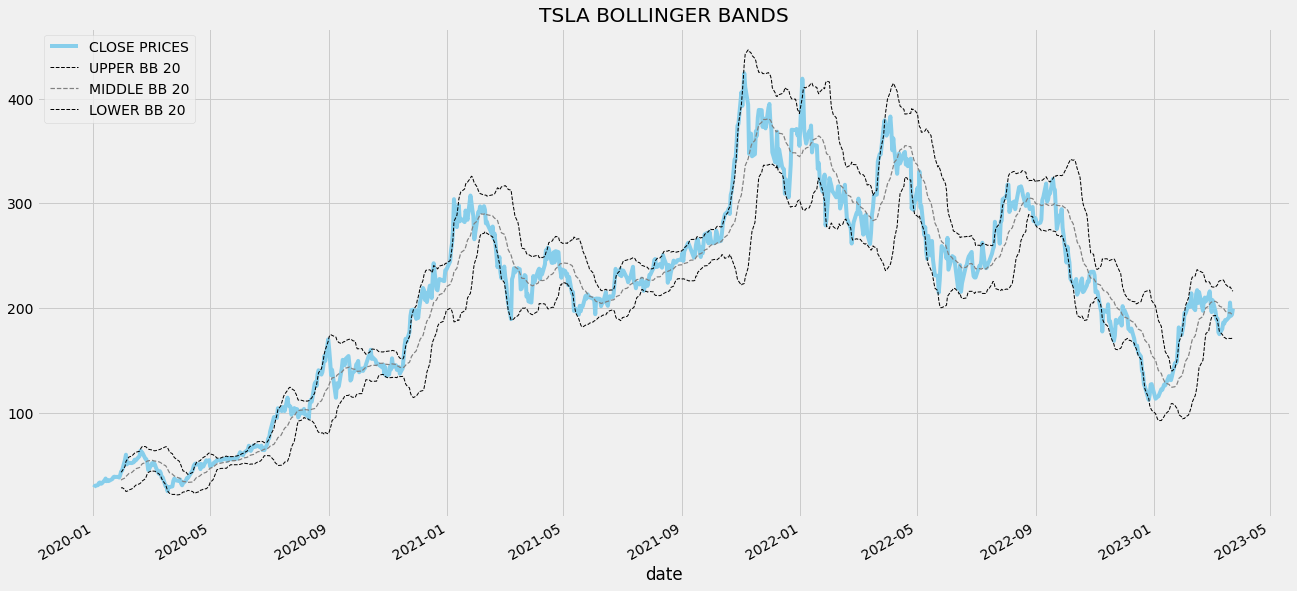

In [15]:
tsla['close'].plot(label = 'CLOSE PRICES', color = 'skyblue')
tsla['upper_bb'].plot(label = 'UPPER BB 20', linestyle = '--', linewidth = 1, color = 'black')
tsla['sma_20'].plot(label = 'MIDDLE BB 20', linestyle = '--', linewidth = 1.2, color = 'grey')
tsla['lower_bb'].plot(label = 'LOWER BB 20', linestyle = '--', linewidth = 1, color = 'black')
plt.legend(loc = 'upper left')
plt.title('TSLA BOLLINGER BANDS')
plt.show()

In [16]:
position = []
for i in range(len(bb_signal)):
    if bb_signal[i] > 1:
        position.append(0)
    else:
        position.append(1)
        
for i in range(len(tsla['close'])):
    if bb_signal[i] == 1:
        position[i] = 1
    elif bb_signal[i] == -1:
        position[i] = 0
    else:
        position[i] = position[i-1]
        
upper_bb = tsla['upper_bb']
lower_bb = tsla['lower_bb']
close_price = tsla['close']
bb_signal = pd.DataFrame(tsla['sma_20']).rename(columns = {0:'bb_signal'}).set_index(tsla.index)
position = pd.DataFrame(position).rename(columns = {0:'bb_position'}).set_index(tsla.index)

frames = [close_price, upper_bb, lower_bb, bb_signal, position]
strategy = pd.concat(frames, join = 'inner', axis = 1)
strategy = strategy.reset_index().drop('date', axis = 1)

strategy

,close,upper_bb,lower_bb,sma_20,bb_position
0,28.7500,NaN,NaN,NaN,1
1,30.2750,NaN,NaN,NaN,1
2,30.8472,NaN,NaN,NaN,1
3,32.8220,NaN,NaN,NaN,1
4,33.3949,NaN,NaN,NaN,1
...,...,...,...,...,...
808,191.2800,219.444904,170.984096,195.2145,1
809,205.1900,220.228242,170.977758,195.6030,1
810,192.5300,218.859375,170.849625,194.8545,1
811,193.7800,216.969382,171.119618,194.0445,1


In [17]:

tsla_ret = pd.DataFrame(np.diff(tsla['close'])).rename(columns = {0:'returns'})
bb_strategy_ret = []

for i in range(len(tsla_ret)):
    try:
        returns = tsla_ret['returns'][i]*strategy['bb_position'][i]
        bb_strategy_ret.append(returns)
    except:
        pass
    
bb_strategy_ret_df = pd.DataFrame(bb_strategy_ret).rename(columns = {0:'bb_returns'})

investment_value = 100000
number_of_stocks = math.floor(investment_value/tsla['close'][-1])
bb_investment_ret = []

for i in range(len(bb_strategy_ret_df['bb_returns'])):
    returns = number_of_stocks*bb_strategy_ret_df['bb_returns'][i]
    bb_investment_ret.append(returns)

bb_investment_ret_df = pd.DataFrame(bb_investment_ret).rename(columns = {0:'investment_returns'})
total_investment_ret = round(sum(bb_investment_ret_df['investment_returns']), 2)
profit_percentage = math.floor((total_investment_ret/investment_value)*100)
print(cl('Profit gained from the BB strategy by investing $100k in TSLA : {}'.format(total_investment_ret), attrs = ['bold']))
print(cl('Profit percentage of the BB strategy : {}%'.format(profit_percentage), attrs = ['bold']))

Profit gained from the BB strategy by investing $100k in TSLA : 12421.69
Profit percentage of the BB strategy : 12%


In [18]:
def get_benchmark(stock_prices, start_date, investment_value):
    spy = get_historic_data('SPY')
    spy = spy.set_index('date')
    spy = spy[spy.index >= start_date]['close']
    benchmark = pd.DataFrame(np.diff(spy)).rename(columns = {0:'benchmark_returns'})
    
    investment_value = investment_value
    number_of_stocks = math.floor(investment_value/stock_prices[-1])
    benchmark_investment_ret = []
    
    for i in range(len(benchmark['benchmark_returns'])):
        returns = number_of_stocks*benchmark['benchmark_returns'][i]
        benchmark_investment_ret.append(returns)

    benchmark_investment_ret_df = pd.DataFrame(benchmark_investment_ret).rename(columns = {0:'investment_returns'})
    return benchmark_investment_ret_df

benchmark = get_benchmark(tsla['close'], '2020-01-01', 100000)

investment_value = 100000
total_benchmark_investment_ret = round(sum(benchmark['investment_returns']), 2)
benchmark_profit_percentage = math.floor((total_benchmark_investment_ret/investment_value)*100)
print(cl('Benchmark profit by investing $100k : {}'.format(total_benchmark_investment_ret), attrs = ['bold']))
print(cl('Benchmark Profit percentage : {}%'.format(benchmark_profit_percentage), attrs = ['bold']))
print(cl('BB Strategy profit is {}% higher than the Benchmark Profit'.format(profit_percentage - benchmark_profit_percentage), attrs = ['bold']))


Benchmark profit by investing $100k : 34523.91
Benchmark Profit percentage : 34%
BB Strategy profit is -22% higher than the Benchmark Profit
